# Erik Sjoberg:  Statistical Techniques in Robotics HW4

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import montecarlo_localization as mcl
import warnings # suppress for display purposes
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

## Approach

For each location in the provided map of the environment, expected range measurements are pre-computed via ray tracing with Brensenham's line algorithm. Tracing in 3-degree steps, this results in 120 binned range measurements for each grid in the 800x800 map. The results are stored in a ~600mb binary file and used as a lookup table to accelerate the particle filter. 

The initial pose for each particle is sampled uniformly over the entire space of valid particle locations, and a movement model is used to project forwards in time the poses of each individual particle. The expected range values of each particle is acquired from the range lookup table for it's current location and orientation, and the actual measurements are compared against this expected range. 

The weights of the particles are updated in a multiplicative fashion, using the sum of a normal and uniform distribution. 

Each update step of the Monte Carlo localization can be summarized by the following pseudo-code, which:
 
 1. Updates particle locations
 2. Updates particle weights
 3. Re-samples particles in proportion to their weights
 4. Adds new particles to the map (if requested)

In [ ]:
def mcl_update(particle_list, msg, target_particles=300, resample=True):
    """Pseudo-code for Monte Carlo localization update of a list of particles
    Actual code located in montecarlo_localization.py:18 mcl_update()"""
    
    # FIRST: Update locations and weights of particles
    for particle in particle_list:
        particle.sample_motion(msg)
        
        if msg is laser_scan:
            particle.update_measurement_likelihood(msg)  # Update particle weight

    # SECOND: Re-sample particles in proportion to particle weight, if re-sampling requested
    if msg is laser_scan and resample:
        
        new_particle_list = sample_list_by_weight(valid_particles, particle_list_weights, 
                                                  max_target_particles=target_particles) 
        if new_particles_per_round > 0:
            # Add a few new particles with average weights
            for _ in range(new_particles_per_round):
                new_particle_list.append(new_particle)
    else:
        new_particle_list = particle_list
        
    return new_particle_list

## Results

As can be seen in the video below (attached - see `./mcl_log1_50k_success.mp4`), successful localization was achieved on Wean Hall dataset. 

In [43]:
mcl.mp4_to_html('./mcl_log1_50k_success.mp4')

Although successful localization was achieved, the current implementation is sensitive to the chosen parameters and further work remains to create a fully robust system. The current system does not converge on the correct location on every run across all datasets, partly as a result of its inability to recover from overconfidence in a similar (but incorrect) pose.

Since many hallways and openings are similar in the given dataset, robust localization is challenging without a more accurate sensor model able to cope with the noise induced by the unexpected human legs present in the dataset.

## Implementation

### Initial Pose Sampling Distribution

The initial pose of particles is sampled uniformly over the entire space of valid particle locations, as defined by a probability of open space greater than 0.8 from the occupancy grid map.

Rejection sampling was used to ensure that the distribution is uniform over the subset of valid poses.

A visualization of 1000 particles initialized at random can be seen below:

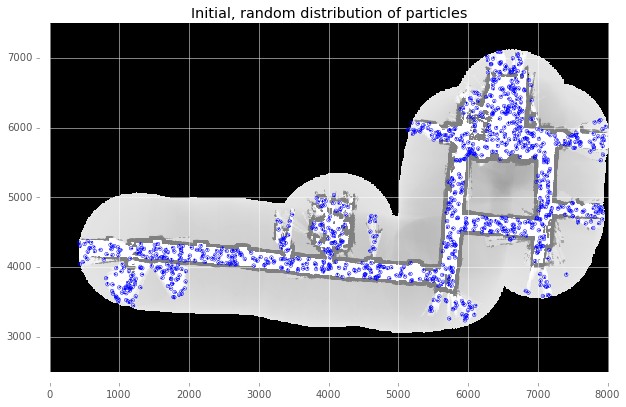

In [4]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
sensor = mcl.laser_sensor()  # Defines sensor measurement model
particle_list = [mcl.robot_particle(global_map, sensor)
                 for _ in range(1000)]
mcl.draw_map_state(global_map, particle_list, rotate=True,
                   title="Initial, random distribution of particles")
plt.show()

### Motion Model

The motion model extracts the relative movement of the actual robot from the log files, and transforms this delta into the coordinate frame of each individual robot. 

Noise is applied to this delta motion for each robot, in proportion to the magnitude of the change in location. The standard deviation of this error as a percentage of the delta was 0.2 and 0.15 for the X and Theta components. The robot particles were assumed to not drift significantly in the Y direction during movement, although Y-direction translation does occur during resampling. 

The following plot shows four sample particles moving with very low error scaling of 0.01 in the x and theta directions. 

As would be expected, the trajectories look largely similar. 

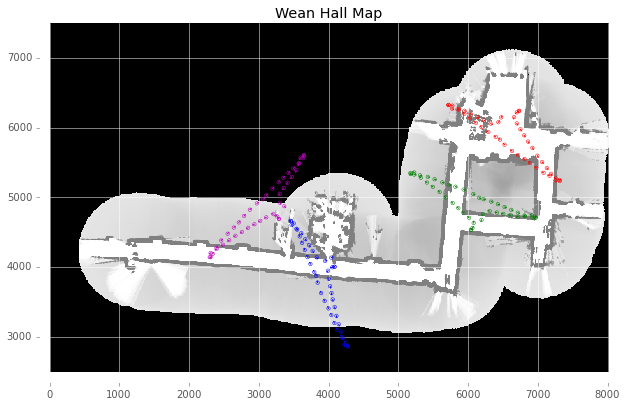

In [5]:
logdata = mcl.load_log('data/log/robotdata1.log.gz')
def plot_motion_example(fwd_err_pct=0.01, theta_err_pct = 0.01):
    colors = ['r', 'g', 'b', 'm']
    fig, ax = plt.subplots(figsize=(10,10))
    plt.hold(True)
    mcl.draw_map_state(global_map, ax=ax)
    for idx in range(4):
        sensor = mcl.laser_sensor()
        particle = mcl.robot_particle(global_map, sensor, fwd_err_pct, theta_err_pct)
        locations = np.array([particle.sample_motion(msg) for msg in logdata.values])
        location_subset = locations[::50]
        for pose in location_subset[:, 0:4]:
            mcl.plot_particle(pose, ax, pass_pose=True, color=colors[idx])
            
plot_motion_example(fwd_err_pct=0.2, theta_err_pct = 0.01)

The following plot shows particle trajectories with a larger error scaling in Theta of 0.1.  Note that some particles do not end up in the starting location (which was the case for the actual robot)

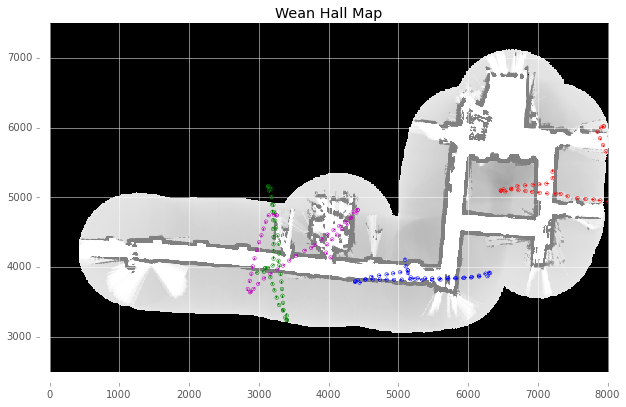

In [6]:
plot_motion_example(fwd_err_pct=0.01, theta_err_pct = 0.1)

### Sensor Model

The sensor model I chose is based upon the sum of probability of a measurement with two error sources: 

1. Normally distributed error about the true measurement
1. Uniformly distributed error across the entire range of measurement


#### Raycasting distances

An efficient integer-based raycasting implementation based on Bresenham's line algorithm allowed for calculation of the distance from any point in the map to the nearest obstacle at any angle. This implementation was able to raycast distances for an 800x800 grid for 120 discrete angles in less than 10 minutes, resulting in a 600mb binary file. 

Although it would have been possible to significantly speed up this algorithm using Cython (C within python), this was not necessary since it was possible to store the pre-computed distance data in a reasonable amount of memory. 

Below is a visualization of the ray-casting algorithm for a variety of angles in a single position in the map.

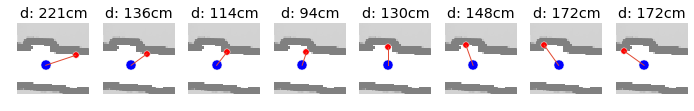

In [34]:
theta = 0
fig, axes = plt.subplots(ncols=8, figsize=(12,4))
for ax in axes: 
    theta += np.pi/10
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)
    ax = mcl.draw_map_state(global_map, ax=ax)
    ax.set_title("d: " + str(int(dist)) + 'cm')
    ax.set_ylim((4000,4500))
    ax.set_xlim((2000,2500))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.scatter(2200, 4200, s=100)
    ax.plot([x, 2200],[y,4200], c='r')
    ax.scatter(x,y, s=40, c='r')

#### High performance achieved by caching pre-computed distances

High performance was achieved on a single core in Python, enabling up to 100,000 initial particles with reasonable performance. 

This performance was enabled chiefly by pre-computing the raycasting distances for each angle in each cell in the occupancy grid. This allows very fast lookup and comparison of the nominal distance measurements that each particle should expect for it's current pose. 

The graphs below show a visualization of several "slices" of the 3-dimensional array of distance data at various orientations for the entire map. 

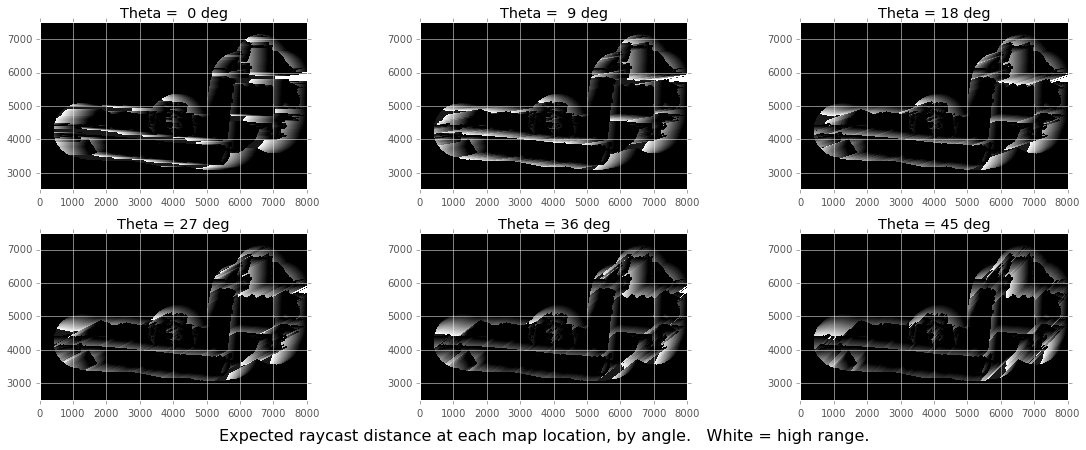

In [31]:
range_array = np.load('./data/range_array_40bin.npy')
slice_theta_deg = 360/40
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 6))
for idx, ax in enumerate(fig.axes):
    ax.imshow(range_array[:,:,idx].T, cmap=plt.cm.gray, interpolation='nearest',
                  origin='lower', extent=(0,8000,0,8000), aspect='equal')
    ax.set_ylim(2500,7500)
    ax.set_xlim(0,8000)
    ax.set_title("Theta = {:2.0f} deg".format(idx*slice_theta_deg))
fig.tight_layout()
fig.suptitle("Expected raycast distance at each map location, by angle."
             "White = high range.", size=16, y=0)


### Resampling Procedure

Particle resampling is achieved by sampling from a multinomial distribution defined by the normalized weight of the particles. 

In addition, the dual purposes of 

1. adaptive particle count and 
2. encouraging particle diversity

are achieved by suppressing excessive repeated samples of the same particle when the current particle count is greater than the target particle count.  As a result, the total count of particles smoothly approaches the target count in a way that allows diverse particles to survive. 

Furthermore, each duplicated particle is slightly perturbed from the original particle, further encouraging diversity. This is especially helpful during the initial phase of localization, when slight shifts in theta can be corrected for as a result of sample duplication - even before movement of the robot begins. 

This resampling code from montecarlo_localization.py is reproduced below:

In [ ]:
def sample_list_by_weight(list_to_sample, list_element_weights, randomize_order=True,
                          perturb=True, max_target_particles=10000):
    """Samples new particles with probability proportional to their weight.
        If current particle count is above max_target_particles,
        duplicate particles are surpressed"""

    new_sampled_list = []
    array_element_weights = np.array(list_element_weights)
    normed_weights = array_element_weights / array_element_weights.sum()
    list_idx_choices = np.random.multinomial(len(normed_weights), normed_weights)
    # list_idx_choices of form [0, 0, 2, 0, 1, 0, 4] for length 7 list_to_sample
    total_particles = 0
    for idx, count in enumerate(list_idx_choices):
        total_particles += 1
        while count > 0:
            if count == 1:
                new_sampled_list.append(list_to_sample[idx])
            # Stop duplicating if max reached
            elif count < 3 or total_particles < max_target_particles: 
                # Need to add copies to new list, not just identical references! 
                new_particle = copy.copy(list_to_sample[idx])
                if perturb:
                    new_particle.new_pose_from_sample_error(10)
                new_sampled_list.append(new_particle)
            count -= 1
    if randomize_order:   # Not required, but nice for random order
        np.random.shuffle(new_sampled_list)
    return new_sampled_list


### Tuned Parameters

* **Initial Particle Count: 50,000**

In order to ensure that a robot appears in an appropriate orientation close to the true robot location, an initial particle count of over 10,000 was found to greatly increase the probability of a successful initial localization. 



* **Target particles: 300**

After initial localization has succeeded, continued localization can be achieved with as few as 300 particles. 



* **Resample period: 10**

By only resampling particles every 10th laser scan, premature convergence can be avoided.  This serves a similar purpose as a low probability scaling factor, allowing the particles to explore more area before the less likely particles are sampled away. 



* **Stdv of sensor measurement gaussian: 70cm**

A relatively high amount of variance in the sensor measurement model's gaussian distribution prevented the particles from prematurely converging on an incorrect location.



* **Weight of uniform measurement likelihood: 0.2**

Applying a uniform measurement likelihood weight of 0.2 serves to counteract the very thin tails of the gaussian distribution. This is critical due to the legs of the observers which appear in this dataset. 



* **Log probability descale: 1000**

This parameter scales the impact that measurement likelihoods have on the actual weight of the particle. Using probabilities directly, the weight of the particles is immediately scaled close to zero as a result of the multiplicative application of many independent sensor readings.



* **Forward movement error fraction: 0.2**
* **Rotational movement error fraction: 0.15**

The two movement error fractions allow for the introduction of drift in the sensor model (and resampling), which allows the particles to correct for inaccurate odometry with their sensor.


## Future Work

### Exponential sensor model component

The most significant piece of future work revolves around improving the sensor model. 

Currently, with probabilistic contributions from a normal and uniform distributions, the sensor model does not handle unexpected close-range objects well. This is especially unfortunate because the current dataset includes human legs which fit this error mode. 

The clearest approach would be to add an exponential component with higher likelihood given to objects being detected close to the robot, between itself and the actual target.  It is my believe that this would significantly improve the robustness of the localization to disturbances such as unexpected objects in the scene. 

### Intelligent re-sampling for recovery

In order to handle situations where the initial localization is inaccurate or the robot is "captured", it would be beneficical to implement a process which will increase the number of random particles significantly when an anomaly is detected, such as running into a wall which was not expected. 

This capability would greatly increase the real-world utility of the localization system since there would be an automated mechanism to recover from false localizations. 

## Extra Credit

### Adaptive number of particles

As mentioned in the Resampling Procedure section sections, I implemented an adaptive number of particles which adjusts the number of remaining particles so as to encourage particle diversity yet still approach the lower number of particles required for efficient inference.

When the number of particles falls below the target, additional duplicate particles are added to the list in order to maintain the required tracking precision. 